In [1]:
!pip install scipy==1.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [2]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import tensorflow as tf
import numpy as np
import pandas as pd
from IPython.display import HTML

from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder

In [3]:
import random

# Python's built-in random library
random.seed(42)

# NumPy
np.random.seed(42)

# PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Scikit-learn (only affects some parts of scikit-learn)
from sklearn.utils import check_random_state
check_random_state(42)


RandomState(MT19937) at 0x7C44698CBE40

In [4]:
import torchvision.models as models
from torch.nn.functional import interpolate
from scipy.linalg import sqrtm

# Use a pre-trained Inception model
inception_model = models.inception_v3(pretrained=True)
inception_model = inception_model.eval()

# Define a function to compute the activations
def get_activations(images, model):
    # Upscale the images to 96x96
    images = interpolate(images, size=(96, 96))
    features = model(images)
    return features.detach().numpy()

# Calculate FID
def calculate_fid(act1, act2):
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 273MB/s] 


In [5]:
# Set path for data source
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/diffusion_model/")

from diffusion_utilities import *

Mounted at /content/gdrive


In [6]:
img_rows = 168
img_cols = 168
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

In [7]:
os.chdir("/content/gdrive/My Drive/Load Diffusion/dataset/")

In [8]:
# Set the path to the folder containing saved files
load_path = "./preprocessed_data_168x168_2years"

# Load saved NumPy arrays
X_train = np.load(os.path.join(load_path, 'X_train.npy'))
X_test = np.load(os.path.join(load_path, 'X_test.npy'))
y_train = np.load(os.path.join(load_path, 'y_train.npy'))
y_test = np.load(os.path.join(load_path, 'y_test.npy'))

# Load saved Pandas DataFrames
train_data = pd.read_pickle(os.path.join(load_path, 'train_data.pkl'))
test_data = pd.read_pickle(os.path.join(load_path, 'test_data.pkl'))
metadata = pd.read_pickle(os.path.join(load_path, 'metadata.pkl'))
metadata_original = pd.read_pickle(os.path.join(load_path, 'metadata_original.pkl'))

In [9]:
def merge_dummified_columns(df, dummified_columns, new_column_name):
    """
    Merges dummified columns into a single column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the dummified columns.
        dummified_columns (list): A list of the names of the dummified columns.
        new_column_name (str): The name of the new column to create.

    Returns:
        pd.DataFrame: The DataFrame with the dummified columns merged into a single new column.
    """
    # Create a new column containing the column name where the value is 1 for each row
    df[new_column_name] = df[dummified_columns].idxmax(axis=1)

    # Drop the dummified columns
    df.drop(dummified_columns, axis=1, inplace=True)

    return df

test_metadata = metadata_original.loc[test_data.columns]

test_metadata = merge_dummified_columns(test_metadata,
                     dummified_columns=['chilledwater', 'electricity', 'gas', 'hotwater', 'steam'],
                     new_column_name='meter_type')
test_metadata = merge_dummified_columns(test_metadata,
                     dummified_columns=['Education', 'Entertainment/public assembly', 'Lodging/residential', 'Office', 'Public services'],
                     new_column_name='building_type')

test_metadata


,lat,lng,year,meter_type,building_type
electricity_Lamb_office_Caitlin_2016,51.497838,-3.186246,2016,electricity,Office
electricity_Rat_public_Kelle_2016,38.903504,-77.005349,2016,electricity,Public services
electricity_Rat_assembly_Ezequiel_2016,38.903504,-77.005349,2016,electricity,Entertainment/public assembly
electricity_Bear_assembly_Roxy_2016,37.871903,-122.260729,2016,electricity,Entertainment/public assembly
gas_Shrew_office_Rose_2017,51.499840,-0.124663,2017,gas,Office
...,...,...,...,...,...
steam_Moose_education_Omar_2016,45.421500,-75.697200,2016,steam,Education
electricity_Rat_public_Chrissy_2017,38.903504,-77.005349,2017,electricity,Public services
electricity_Hog_office_Merilyn_2016,44.978782,-93.255398,2016,electricity,Office
steam_Bull_assembly_Amalia_2016,30.267200,-97.743100,2016,steam,Entertainment/public assembly


In [10]:
X_train = np.tile(X_train, (1, 1, 1, channels))
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_train.shape

(2702, 1, 168, 168)

In [11]:
X_test = np.tile(X_test, (1, 1, 1, channels))
X_test = np.transpose(X_test, (0, 3, 1, 2))
X_test.shape

(901, 1, 168, 168)

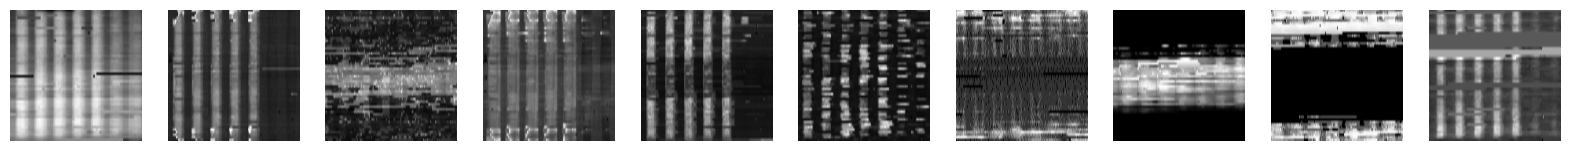

In [12]:
import random
# Generate 10 unique random indices
random_indices = random.sample(range(X_train.shape[0]), 10)

# Extract the randomly selected images
random_images = X_train[random_indices]

# Now random_images has shape [10, 1, 64, 64]
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for idx, ax in enumerate(axes):
    ax.imshow(random_images[idx].squeeze(), cmap='gray') # squeeze to remove the channel dimension
    ax.axis('off') # to remove the axes for clarity

plt.show()

In [13]:
y_train.shape

(2702, 13)

In [14]:
y_test.shape

(901, 13)

In [15]:
metadata_test = metadata.loc[test_data.columns]

In [16]:
# Dims of meta
dims_meta = y_test.shape[1]
dims_meta

13

In [17]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=64):  # cfeat - context features
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height

        self.init_conv = ResidualConvBlock(in_channels, n_feat)

        # Adding third down-sampling layer
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 4 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d((self.h//8)), nn.GELU())

        self.timeembed1 = EmbedFC(1, 4 * n_feat)
        self.timeembed2 = EmbedFC(1, 2 * n_feat)
        self.timeembed3 = EmbedFC(1, 1 * n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 4 * n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 2 * n_feat)
        self.contextembed3 = EmbedFC(n_cfeat, 1 * n_feat)

        # Adding third up-sampling layer
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(4 * n_feat, 4 * n_feat, self.h//8, self.h//8),
            nn.GroupNorm(8, 4 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(8 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, 1 * n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)  # New added layer

        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)

        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)

        hiddenvec = self.to_vec(down3)

        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 4, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 4, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat * 2, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat * 2, 1, 1)
        cemb3 = self.contextembed3(c).view(-1, self.n_feat, 1, 1)
        temb3 = self.timeembed3(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1 * up1 + temb1, down3)
        up3 = self.up2(cemb2 * up2 + temb2, down2)
        up4 = self.up3(cemb3 * up3 + temb3, down1)

        out = self.out(torch.cat((up4, x), 1))
        return out


In [18]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = int(y_train.shape[1]) # context vector is of size 7
height = 168 # 16x16 image
save_dir = './weights_168x168/'

# training hyperparameters
batch_size = 10 #100
n_epoch = 500
lrate=1e-3

In [19]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

In [20]:
# construct model
nn_model = ContextUnet(in_channels=channels, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [21]:
#dataset = MNIST("./data", train=True, download=True, transform=tf)
import torch
from torch.utils.data import TensorDataset

# Convert the NumPy arrays to PyTorch tensors
x_tensor = torch.from_numpy(X_train)
y_tensor = torch.from_numpy(y_train)

# Create a TensorDataset from the tensors
dataset = TensorDataset(x_tensor, y_tensor)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [22]:
# reset neural network
nn_model = ContextUnet(in_channels=channels, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

# re setup optimizer
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [23]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [24]:
def show_images(imgs, nrow=2):
  _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
  axs = axs.flatten()

  if imgs.shape[1]==1:
    imgs = imgs.repeat(1, 3, 1, 1)

  for img, ax in zip(imgs, axs):
      img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(img)
  plt.show()

In [25]:
# sample with context using standard algorithm
@torch.no_grad()
def sample_ddpm_context(n_sample, context, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, channels, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [26]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [27]:
def r_squared(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def rmse(a, b):
    return torch.sqrt(torch.mean((a - b) ** 2))

In [28]:
print(test_data.loc[:,::5].columns[:10])

Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')


epoch 0


100%|██████████| 271/271 [00:39<00:00,  6.83it/s]


Epoch Loss: 0.15283158460693827
saved model at ./weights_168x168/diffusion_model_0.pth
RMSE: 1.269127368927002
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(6.0177, device='cuda:0') tensor(-5.4109, device='cuda:0')


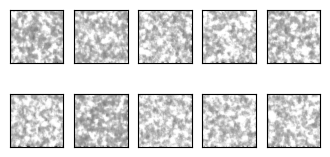

epoch 1


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.10627933149655587
epoch 2


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.10622470535172968
epoch 3


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.10098629941084727
epoch 4


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.08813949792243787
epoch 5


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.08516402805492117
epoch 6


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.08422556096804758
epoch 7


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.07863838601225087
epoch 8


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.08312118031785606
epoch 9


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.07331825224029732
epoch 10


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.07417769428356327
epoch 11


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.07451827046753516
epoch 12


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.06830991036344554
epoch 13


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.07056766262491031
epoch 14


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.06680970871305554
epoch 15


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.06503702919394108
epoch 16


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.06704474638501437
epoch 17


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.06005666550675001
epoch 18


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.06211247561994349
epoch 19


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.06326111888932236
epoch 20


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.06296114015609466
epoch 21


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.06141396148673283
epoch 22


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.06521419517874608
epoch 23


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.061740541067730456
epoch 24


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.059855025069190125
epoch 25


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05979827034366197
saved model at ./weights_168x168/diffusion_model_25.pth
RMSE: 0.6845401525497437
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.8479, device='cuda:0') tensor(-1.0621, device='cuda:0')


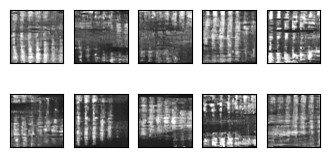

epoch 26


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05507938437699942
epoch 27


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05649624773682648
epoch 28


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05941717788865755
epoch 29


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.058769170906243506
epoch 30


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.06334609207027073
epoch 31


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.06114305601441525
epoch 32


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.0584794770981223
epoch 33


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.06030883663248037
epoch 34


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05707712128339164
epoch 35


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05416521492561951
epoch 36


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05606958226599761
epoch 37


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.056927557740827875
epoch 38


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.0558477089382928
epoch 39


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05651221477265068
epoch 40


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05492759115884005
epoch 41


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05763802021858712
epoch 42


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05520816356789087
epoch 43


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05820917032274153
epoch 44


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05759850991168145
epoch 45


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05715345197298815
epoch 46


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.053592117389877125
epoch 47


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05390382078184138
epoch 48


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04955894722795712
epoch 49


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.052192384614248334
epoch 50


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.052299846467180555
saved model at ./weights_168x168/diffusion_model_50.pth
RMSE: 0.5912104249000549
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.2901, device='cuda:0') tensor(-0.9190, device='cuda:0')


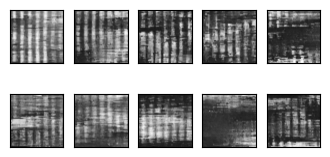

epoch 51


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05209144069108686
epoch 52


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05261460007975957
epoch 53


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05158684881424662
epoch 54


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05754333519723912
epoch 55


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.06138570315970926
epoch 56


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05165559416155698
epoch 57


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.057167474061037615
epoch 58


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05339386635648973
epoch 59


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05409300805505956
epoch 60


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.054345502727750926
epoch 61


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05652046950217818
epoch 62


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05027855442823134
epoch 63


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05437876109542442
epoch 64


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.052147623705694875
epoch 65


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05473101146199579
epoch 66


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05230955346710842
epoch 67


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05621403331156971
epoch 68


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.047249665729550305
epoch 69


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.052200391653210367
epoch 70


100%|██████████| 271/271 [00:32<00:00,  8.37it/s]


Epoch Loss: 0.04878777392359787
epoch 71


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04896502370939236
epoch 72


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.054318967122392134
epoch 73


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.050808612157580375
epoch 74


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05152732418932543
epoch 75


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05428938274495166
saved model at ./weights_168x168/diffusion_model_75.pth
RMSE: 0.8124187588691711
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.3348, device='cuda:0') tensor(-0.7100, device='cuda:0')


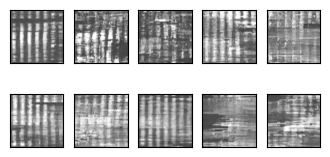

epoch 76


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04897437043096252
epoch 77


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.051052779651752145
epoch 78


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05142594456614246
epoch 79


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.0539504373480473
epoch 80


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04817721511776872
epoch 81


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.055127369372236
epoch 82


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05198717749732584
epoch 83


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05236359963853366
epoch 84


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.0517701065147165
epoch 85


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.048690263728346554
epoch 86


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.052799197542738874
epoch 87


100%|██████████| 271/271 [00:32<00:00,  8.37it/s]


Epoch Loss: 0.05024206129459465
epoch 88


100%|██████████| 271/271 [00:32<00:00,  8.37it/s]


Epoch Loss: 0.04846879808967624
epoch 89


100%|██████████| 271/271 [00:32<00:00,  8.37it/s]


Epoch Loss: 0.05230405790270805
epoch 90


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04925098114842858
epoch 91


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.050186248099245816
epoch 92


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05008280082482061
epoch 93


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05066893251124783
epoch 94


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05275202670385477
epoch 95


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05013189725131072
epoch 96


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04946219858565674
epoch 97


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05057031057458852
epoch 98


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05172637134457069
epoch 99


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05340286834351031
epoch 100


100%|██████████| 271/271 [00:32<00:00,  8.24it/s]


Epoch Loss: 0.05020999298276332
saved model at ./weights_168x168/diffusion_model_100.pth
RMSE: 0.7049049735069275
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.2974, device='cuda:0') tensor(-0.9900, device='cuda:0')


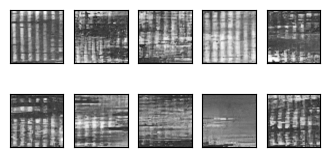

epoch 101


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05077008821149236
epoch 102


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.049600538531338924
epoch 103


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.049434147467596175
epoch 104


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04863129126945875
epoch 105


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05145868167068081
epoch 106


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04848344291550042
epoch 107


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05147723373836697
epoch 108


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.048705925842802075
epoch 109


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04795418936085657
epoch 110


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05211207165290014
epoch 111


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.049790457492467445
epoch 112


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.046983160489200995
epoch 113


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.047187614292456215
epoch 114


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.0492987919588508
epoch 115


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05135997989974449
epoch 116


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04935312515547382
epoch 117


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.051080327019665896
epoch 118


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04911683617688963
epoch 119


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.054147622800634905
epoch 120


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.049246333305796135
epoch 121


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05037327920519695
epoch 122


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05007250770940222
epoch 123


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05001969798038477
epoch 124


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04693493657707618
epoch 125


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05096918847360322
saved model at ./weights_168x168/diffusion_model_125.pth
RMSE: 0.8978191018104553
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.6708, device='cuda:0') tensor(-0.5945, device='cuda:0')


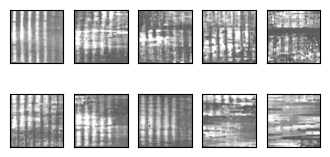

epoch 126


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04881208664754825
epoch 127


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.05251729956611551
epoch 128


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04660949770471157
epoch 129


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04912132535531869
epoch 130


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04844657532918882
epoch 131


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04893227729334657
epoch 132


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04729480259343844
epoch 133


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04993580145472695
epoch 134


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05089489245491714
epoch 135


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04682475802870089
epoch 136


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.0471980882399609
epoch 137


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.045765341878988924
epoch 138


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.050389734366599374
epoch 139


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04616177136016618
epoch 140


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.0469081829425731
epoch 141


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04812863520157568
epoch 142


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.052232867026034864
epoch 143


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04735679482109845
epoch 144


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04607019414850322
epoch 145


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04727001702138034
epoch 146


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04863369339867409
epoch 147


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.044352539760022805
epoch 148


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04660278561824032
epoch 149


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.047949294591446256
epoch 150


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.048010202570615605
saved model at ./weights_168x168/diffusion_model_150.pth
RMSE: 0.7948756217956543
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.2329, device='cuda:0') tensor(-0.5476, device='cuda:0')


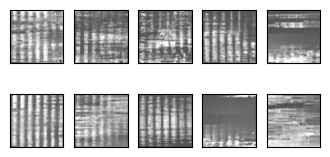

epoch 151


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.050788611929684986
epoch 152


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.0479962311571677
epoch 153


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04930535214523548
epoch 154


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04807597077949956
epoch 155


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05099828790691149
epoch 156


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04585648434858673
epoch 157


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04900172997929321
epoch 158


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.047853690380491726
epoch 159


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.048024365303838606
epoch 160


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.048089917525786535
epoch 161


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04373876109712403
epoch 162


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04667217892378129
epoch 163


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.05149194438481271
epoch 164


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.045289912781715944
epoch 165


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04720596332065211
epoch 166


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05143491514508245
epoch 167


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04742409794752888
epoch 168


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.048239830741315146
epoch 169


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04285020258525091
epoch 170


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04446048481901936
epoch 171


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04683938646530973
epoch 172


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04817972455613617
epoch 173


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04547551057449236
epoch 174


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04915178217839216
epoch 175


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04754133136063209
saved model at ./weights_168x168/diffusion_model_175.pth
RMSE: 0.8828811049461365
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.4929, device='cuda:0') tensor(-0.6726, device='cuda:0')


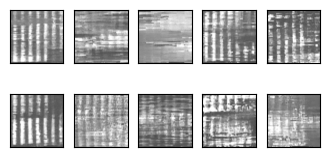

epoch 176


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04719396489088138
epoch 177


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04681572117292875
epoch 178


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04643430406695088
epoch 179


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.046868890130418145
epoch 180


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04490760045050475
epoch 181


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04780798633771904
epoch 182


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.051102237397894205
epoch 183


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.0445792449232727
epoch 184


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.050122707664650414
epoch 185


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04537846191916821
epoch 186


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.045470945181400685
epoch 187


100%|██████████| 271/271 [00:32<00:00,  8.36it/s]


Epoch Loss: 0.04965487331138216
epoch 188


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.05152916929743002
epoch 189


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04878407808852372
epoch 190


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.0470205593211542
epoch 191


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.044916413276803395
epoch 192


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04716529442182986
epoch 193


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04749711028410197
epoch 194


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04618739148918058
epoch 195


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04410759610814692
epoch 196


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04735174199318809
epoch 197


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04501648335133394
epoch 198


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04823035687531217
epoch 199


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.048331220990830405
epoch 200


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04603063768614427
saved model at ./weights_168x168/diffusion_model_200.pth
RMSE: 0.9294552803039551
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.4101, device='cuda:0') tensor(-0.4556, device='cuda:0')


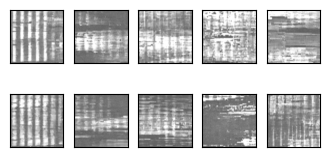

epoch 201


100%|██████████| 271/271 [00:32<00:00,  8.25it/s]


Epoch Loss: 0.04652486934594645
epoch 202


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.047093981820265196
epoch 203


100%|██████████| 271/271 [00:32<00:00,  8.32it/s]


Epoch Loss: 0.04384991116271907
epoch 204


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.046938017957476125
epoch 205


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04757792642340064
epoch 206


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04288655148846582
epoch 207


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.045171063774818644
epoch 208


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.046196286080274526
epoch 209


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.0448701512996396
epoch 210


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04687984167800948
epoch 211


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.044261166573299364
epoch 212


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04785849871216995
epoch 213


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04728126538250719
epoch 214


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04896994496221444
epoch 215


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.0461264267508834
epoch 216


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.050806297473884376
epoch 217


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04522615739030977
epoch 218


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04645862274741362
epoch 219


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04604130661513697
epoch 220


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.043123891354603795
epoch 221


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04749203011276702
epoch 222


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04756376795673475
epoch 223


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04484423095484116
epoch 224


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04082445742741117
epoch 225


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.0453363949281758
saved model at ./weights_168x168/diffusion_model_225.pth
RMSE: 0.8909609913825989
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.4632, device='cuda:0') tensor(-0.6339, device='cuda:0')


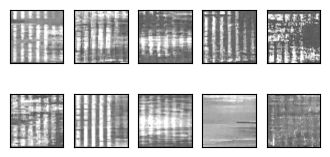

epoch 226


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.0475648910415486
epoch 227


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04640839060912823
epoch 228


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.0451906448121894
epoch 229


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04318508015416315
epoch 230


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.043907319243681166
epoch 231


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.044560960085883845
epoch 232


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.044272088457751206
epoch 233


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04340447498076489
epoch 234


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.047118362164764054
epoch 235


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.0476107875628799
epoch 236


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04427307460893536
epoch 237


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.043644202254520134
epoch 238


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04330994800159302
epoch 239


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04640229038741247
epoch 240


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.045136268303911736
epoch 241


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04856324304115178
epoch 242


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04446688445106259
epoch 243


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.0465636441614685
epoch 244


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.041875634042587394
epoch 245


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04349479842174977
epoch 246


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04607129148018591
epoch 247


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04473068156602665
epoch 248


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.047650952079433026
epoch 249


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04787043324668249
epoch 250


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04650808989097849
saved model at ./weights_168x168/diffusion_model_250.pth
RMSE: 0.9114856719970703
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.4484, device='cuda:0') tensor(-0.5586, device='cuda:0')


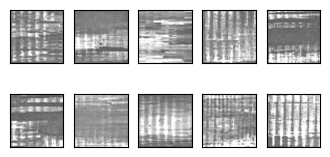

epoch 251


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04764265129282534
epoch 252


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04695247523950557
epoch 253


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.042484896021252466
epoch 254


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04615231527606665
epoch 255


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04599562305888347
epoch 256


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04514276344205401
epoch 257


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.045111114653239776
epoch 258


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.044343976267850596
epoch 259


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.048050324351791414
epoch 260


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04375608299851995
epoch 261


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.047606531695576174
epoch 262


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.045585121074519584
epoch 263


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.0485357211591724
epoch 264


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04894908362264123
epoch 265


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04498837616748255
epoch 266


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.045338581976003094
epoch 267


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.0461470590512581
epoch 268


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04482050325611531
epoch 269


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04228610801080936
epoch 270


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.044316679162378816
epoch 271


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04489179604559642
epoch 272


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04352743787745983
epoch 273


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04658733300754725
epoch 274


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.043488101778565685
epoch 275


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.044046543128754105
saved model at ./weights_168x168/diffusion_model_275.pth
RMSE: 0.6585882306098938
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.2841, device='cuda:0') tensor(-0.8883, device='cuda:0')


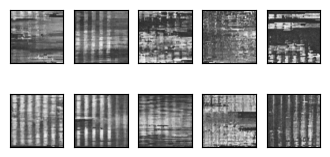

epoch 276


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04440996990576936
epoch 277


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.045588779340522204
epoch 278


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04610829235387904
epoch 279


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.046557474763706544
epoch 280


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.048709713068629215
epoch 281


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04647990834394064
epoch 282


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04126536093800023
epoch 283


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04928255405936844
epoch 284


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.045084815305688614
epoch 285


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04457595739668283
epoch 286


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.045659270694280024
epoch 287


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04654836401040924
epoch 288


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04575089319021444
epoch 289


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04361521756290235
epoch 290


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.046783916626427995
epoch 291


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04503863916313104
epoch 292


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04100095895479856
epoch 293


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.0440128613237594
epoch 294


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.044927102231808916
epoch 295


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.045278732960432
epoch 296


100%|██████████| 271/271 [00:32<00:00,  8.32it/s]


Epoch Loss: 0.044022564042524547
epoch 297


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.042889299474715
epoch 298


100%|██████████| 271/271 [00:32<00:00,  8.32it/s]


Epoch Loss: 0.043937480928998345
epoch 299


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04645973961710985
epoch 300


100%|██████████| 271/271 [00:32<00:00,  8.32it/s]


Epoch Loss: 0.043923961227189244
saved model at ./weights_168x168/diffusion_model_300.pth
RMSE: 0.8009918332099915
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.4028, device='cuda:0') tensor(-0.6745, device='cuda:0')


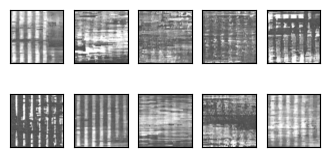

epoch 301


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.044559394933001525
epoch 302


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04252410963705201
epoch 303


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.043364096162290866
epoch 304


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04328862606028844
epoch 305


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04674183840715632
epoch 306


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.042766025341442374
epoch 307


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04642237588330224
epoch 308


100%|██████████| 271/271 [00:32<00:00,  8.32it/s]


Epoch Loss: 0.045743977779443494
epoch 309


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04246560759100087
epoch 310


100%|██████████| 271/271 [00:32<00:00,  8.32it/s]


Epoch Loss: 0.04321958988774362
epoch 311


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04453440066908119
epoch 312


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04225537613140783
epoch 313


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04169035083021474
epoch 314


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04635697162995369
epoch 315


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.044206768729658695
epoch 316


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.043899150407182334
epoch 317


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04255815987763892
epoch 318


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04703776890968705
epoch 319


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04423441069039114
epoch 320


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.045532480607795564
epoch 321


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04336974633397102
epoch 322


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.041058832274344356
epoch 323


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04150030187527027
epoch 324


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04045710071570814
epoch 325


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04277044089555713
saved model at ./weights_168x168/diffusion_model_325.pth
RMSE: 0.5756840705871582
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.1512, device='cuda:0') tensor(-0.9299, device='cuda:0')


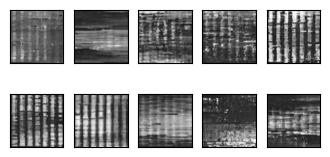

epoch 326


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.043721752661379995
epoch 327


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.044948160153473436
epoch 328


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.042130849258871096
epoch 329


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04331085677825712
epoch 330


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.042664818152118596
epoch 331


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04356975677832136
epoch 332


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04127956536466194
epoch 333


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04268703014655142
epoch 334


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04202594149452239
epoch 335


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04462547466756838
epoch 336


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.042781323852615495
epoch 337


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04526199449568547
epoch 338


100%|██████████| 271/271 [00:32<00:00,  8.31it/s]


Epoch Loss: 0.04447422261655715
epoch 339


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04349401252639799
epoch 340


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04294291972371705
epoch 341


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04556523421538712
epoch 342


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04001174980260748
epoch 343


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.0465609133759053
epoch 344


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04424906647643865
epoch 345


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.044075372904655956
epoch 346


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04712401475238431
epoch 347


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.046089522133330466
epoch 348


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04215065573472736
epoch 349


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04216325232016809
epoch 350


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04219936355828167
saved model at ./weights_168x168/diffusion_model_350.pth
RMSE: 0.8940445780754089
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.5025, device='cuda:0') tensor(-0.7069, device='cuda:0')


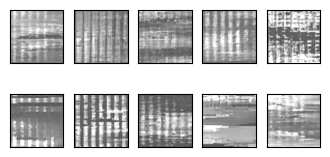

epoch 351


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.0414979120182059
epoch 352


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04136674381307982
epoch 353


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.045963261182835786
epoch 354


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04490959400489816
epoch 355


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04440681132353925
epoch 356


100%|██████████| 271/271 [00:32<00:00,  8.32it/s]


Epoch Loss: 0.04376941285271376
epoch 357


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.040127896063710214
epoch 358


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04399696716994075
epoch 359


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04427169581335656
epoch 360


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.046661334537138055
epoch 361


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04643327284284706
epoch 362


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04423388303858933
epoch 363


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04056290520966823
epoch 364


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04484076354037489
epoch 365


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.040957936753322995
epoch 366


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.043908921547227184
epoch 367


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04417246933236058
epoch 368


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04440341939603243
epoch 369


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04193653438946514
epoch 370


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04292925116880986
epoch 371


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.044134840349464015
epoch 372


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.040054992937596304
epoch 373


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04527697013261491
epoch 374


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04201724884449075
epoch 375


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04377099637859724
saved model at ./weights_168x168/diffusion_model_375.pth
RMSE: 0.7379049062728882
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.3081, device='cuda:0') tensor(-0.7926, device='cuda:0')


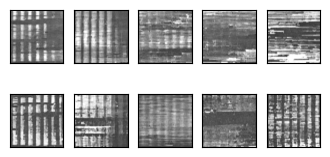

epoch 376


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04215062127149633
epoch 377


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04375693992955603
epoch 378


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04161256308172489
epoch 379


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04246433759864241
epoch 380


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.043675713197068686
epoch 381


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.042614810689390256
epoch 382


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04084738120230472
epoch 383


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04077658781135709
epoch 384


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04155137179491567
epoch 385


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04109558547465509
epoch 386


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04234102759011969
epoch 387


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04148301934716859
epoch 388


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04164442751596156
epoch 389


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04168226998780487
epoch 390


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04093917696547739
epoch 391


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04467842813299426
epoch 392


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04490922908453319
epoch 393


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.041011927217224485
epoch 394


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04276916898728599
epoch 395


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.042513410366617994
epoch 396


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04365731948020961
epoch 397


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.03998444133568761
epoch 398


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04086631711192663
epoch 399


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04601310663495722
epoch 400


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.037996173867220366
saved model at ./weights_168x168/diffusion_model_400.pth
RMSE: 0.6688393950462341
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.1699, device='cuda:0') tensor(-1.0042, device='cuda:0')


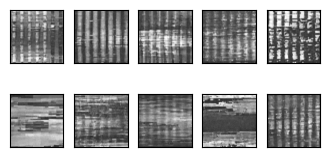

epoch 401


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04256250527498357
epoch 402


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04164105785986567
epoch 403


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04337991791007511
epoch 404


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04572522370282189
epoch 405


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04344478959038964
epoch 406


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.044059071825160834
epoch 407


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04095573110138221
epoch 408


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04344681916995544
epoch 409


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04069840721700107
epoch 410


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04301784462742232
epoch 411


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04141942416558324
epoch 412


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04321881143609921
epoch 413


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.040880941507506194
epoch 414


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04167057119388944
epoch 415


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04287353514288157
epoch 416


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.043073401619711155
epoch 417


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04345695541078754
epoch 418


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.041797627046673363
epoch 419


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.042876223988858535
epoch 420


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.043164021715288124
epoch 421


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04031513124271348
epoch 422


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.03935802826439666
epoch 423


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.040122563507394154
epoch 424


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.04032297504419715
epoch 425


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04362502690779244
saved model at ./weights_168x168/diffusion_model_425.pth
RMSE: 0.6760233640670776
Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Hog_office_Marlena_2017',
       'chilledwater_Bull_education_Venita_2017',
       'electricity_Bear_education_Clint_2016',
       'steam_Bull_education_Dora_2016',
       'chilledwater_Fox_education_Kendrick_2016',
       'electricity_Rat_assembly_Suzanne_2016',
       'chilledwater_Eagle_lodging_Dawn_2016',
       'electricity_Rat_office_Mei_2016'],
      dtype='object')
tensor(1.2047, device='cuda:0') tensor(-0.9158, device='cuda:0')


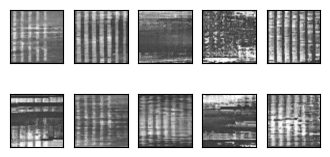

epoch 426


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.041311085920925236
epoch 427


100%|██████████| 271/271 [00:32<00:00,  8.35it/s]


Epoch Loss: 0.03997502390469675
epoch 428


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.03946732964007548
epoch 429


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04225302803608489
epoch 430


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04258755877325346
epoch 431


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.03988965192888743
epoch 432


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04186956803666641
epoch 433


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04438974727220091
epoch 434


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.040207874626127446
epoch 435


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.043159484196578
epoch 436


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04442171237132481
epoch 437


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.040833961058792924
epoch 438


100%|██████████| 271/271 [00:32<00:00,  8.26it/s]


Epoch Loss: 0.04077645966772856
epoch 439


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.038845225098341825
epoch 440


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.03978422512747072
epoch 441


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04314084484317508
epoch 442


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.043121156538321166
epoch 443


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04308100227383395
epoch 444


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.03903268906889257
epoch 445


100%|██████████| 271/271 [00:32<00:00,  8.33it/s]


Epoch Loss: 0.04069784008021504
epoch 446


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.041675396748162064
epoch 447


100%|██████████| 271/271 [00:32<00:00,  8.32it/s]


Epoch Loss: 0.0423057911250864
epoch 448


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.040426292315785296
epoch 449


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]


Epoch Loss: 0.04045430776350393
epoch 450


100%|██████████| 271/271 [00:32<00:00,  8.34it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Epoch Loss: 0.04247344048810621
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-f9ea0891360d>", line 49, in <cell line: 9>
    os.mkdir(save_dir)
OSError: [Errno 107] Transport endpoint is not connected: './weights_168x168/'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offs

In [ ]:
# training with context code
# set into train mode

nn_model.train()

list_fid_score = []
list_rmse_score = []

for ep in range(n_epoch):
    print(f'epoch {ep}')

    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(dataloader, mininterval=2 )
    epoch_loss = 0.0   # initialize epoch loss
    n_batches = 0      # count number of batches
    for x, c in pbar:   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)

        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)

        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
        x_pert = perturb_input(x, t, noise)

        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps, c=c)

        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        epoch_loss += loss.item()
        n_batches += 1
        loss.backward()

        optim.step()

    print(f'Epoch Loss: {epoch_loss/n_batches}')  # print average loss per batch in the epoch


    # save model periodically
    if ep%25==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"diffusion_model_{ep}.pth")
        print('saved model at ' + save_dir + f"diffusion_model_{ep}.pth")

        ctx = torch.tensor(y_test[:10,:]).float().to(device)
        samples, _ = sample_ddpm_context(ctx.shape[0], ctx)

        p = samples.repeat(1, 3, 1, 1).cpu()
        q = torch.from_numpy(X_test[:10]).repeat(1, 3, 1, 1)

        # Get activations
        #act_p = get_activations(p, inception_model)
        #act_q = get_activations(q, inception_model)

        # Calculate FID
        #fid_score = calculate_fid(act_p, act_q)
        #print('FID: '+str(fid_score))
        #list_fid_score.append(fid_score)

        # Calculate RMSE
        rmse_score = rmse(p, q).item()
        print('RMSE: '+str(rmse_score))
        list_rmse_score.append(rmse_score)

        # Calculate R2
        #print('R2: '+str(r_squared(p, q)))
        print(test_data.loc[:,::5].columns[:10])
        print(samples.max(),samples.min())
        show_images(samples[:10])

In [40]:
#df_plot = pd.DataFrame(data = [list_fid_score, list_rmse_score], index=['FID','RMSE']).T
#df_plot.index = df_plot.index*25
#plt.figure()
#df_plot.plot(secondary_y=['RMSE'])

[]

In [30]:
# visualize samples with randomly selected context
plt.clf()
ctx = F.one_hot(torch.randint(0, n_cfeat, (32,)), n_cfeat).to(device=device).float()
samples, intermediate = sample_ddpm_context(32, ctx)
animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm_context.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Rat_public_Kelle_2016',
       'electricity_Rat_assembly_Ezequiel_2016',
       'electricity_Bear_assembly_Roxy_2016', 'gas_Shrew_office_Rose_2017',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Rat_education_Nellie_2017',
       'chilledwater_Bull_education_Miquel_2017',
       'hotwater_Fox_lodging_Stephen_2016',
       'electricity_Rat_assembly_Damaris_2017'],
      dtype='object')


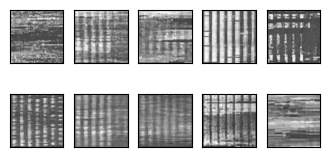

In [31]:
# user defined context
print(test_data.columns[:10])
ctx = torch.tensor(y_test[:10]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Rat_public_Kelle_2016',
       'electricity_Rat_assembly_Ezequiel_2016',
       'electricity_Bear_assembly_Roxy_2016', 'gas_Shrew_office_Rose_2017',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Rat_education_Nellie_2017',
       'chilledwater_Bull_education_Miquel_2017',
       'hotwater_Fox_lodging_Stephen_2016',
       'electricity_Rat_assembly_Damaris_2017'],
      dtype='object')


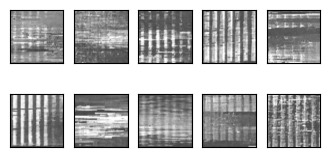

In [32]:
# user defined context
print(test_data.columns[:10])
ctx = torch.tensor(y_test[:10]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

Index(['electricity_Lamb_office_Caitlin_2016',
       'electricity_Rat_public_Kelle_2016',
       'electricity_Rat_assembly_Ezequiel_2016',
       'electricity_Bear_assembly_Roxy_2016', 'gas_Shrew_office_Rose_2017',
       'electricity_Lamb_assembly_Cherie_2017',
       'electricity_Rat_education_Nellie_2017',
       'chilledwater_Bull_education_Miquel_2017',
       'hotwater_Fox_lodging_Stephen_2016',
       'electricity_Rat_assembly_Damaris_2017'],
      dtype='object')


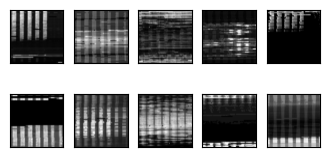

In [33]:
# user defined context
print(test_data.columns[:10])
ctx = torch.tensor(X_test[:10]).float().to(device)
show_images(ctx)

Index(['gas_Lamb_assembly_Corliss_2016',
       'chilledwater_Hog_education_Sonia_2016',
       'electricity_Rat_assembly_Pauline_2017',
       'chilledwater_Eagle_assembly_Ian_2017',
       'chilledwater_Bull_education_Venita_2017',
       'steam_Moose_education_Diane_2016', 'steam_Bull_education_Clarice_2016',
       'gas_Bobcat_education_Alissa_2017',
       'electricity_Rat_assembly_Kristine_2016',
       'electricity_Bear_education_Clint_2016'],
      dtype='object')


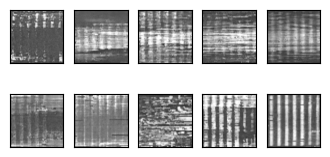

In [34]:
# user defined context
print(test_data.columns[11:21])
ctx = torch.tensor(y_test[11:21]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

Index(['gas_Lamb_assembly_Corliss_2016',
       'chilledwater_Hog_education_Sonia_2016',
       'electricity_Rat_assembly_Pauline_2017',
       'chilledwater_Eagle_assembly_Ian_2017',
       'chilledwater_Bull_education_Venita_2017',
       'steam_Moose_education_Diane_2016', 'steam_Bull_education_Clarice_2016',
       'gas_Bobcat_education_Alissa_2017',
       'electricity_Rat_assembly_Kristine_2016',
       'electricity_Bear_education_Clint_2016'],
      dtype='object')


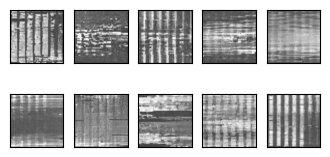

In [35]:
# user defined context
print(test_data.columns[11:21])
ctx = torch.tensor(y_test[11:21]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

Index(['gas_Lamb_assembly_Corliss_2016',
       'chilledwater_Hog_education_Sonia_2016',
       'electricity_Rat_assembly_Pauline_2017',
       'chilledwater_Eagle_assembly_Ian_2017',
       'chilledwater_Bull_education_Venita_2017',
       'steam_Moose_education_Diane_2016', 'steam_Bull_education_Clarice_2016',
       'gas_Bobcat_education_Alissa_2017',
       'electricity_Rat_assembly_Kristine_2016',
       'electricity_Bear_education_Clint_2016'],
      dtype='object')


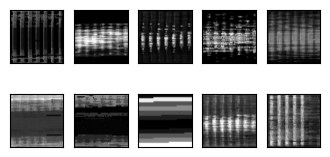

In [36]:
# user defined context
print(test_data.columns[11:21])
ctx = torch.tensor(X_test[11:21]).float().to(device)
show_images(ctx)